In [2]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tkinter as tk
from tkinter import messagebox
import joblib
import pickle

In [3]:
# file path for Monthly Performance Data Files
MPD2008 = pd.read_csv(r"C:\Users\yxu\Desktop\mortgage refinancing\Monthly Performance Data File_2008.txt", delimiter='|', low_memory=False)
MPD2020 = pd.read_csv(r"C:\Users\yxu\Desktop\mortgage refinancing\Monthly Performance Data File_2020.txt", delimiter='|', low_memory=False)
MPD2022 = pd.read_csv(r"C:\Users\yxu\Desktop\mortgage refinancing\Monthly Performance Data File_2022.txt", delimiter='|', low_memory=False)

# file path for Origination Data Files
ODF2008 = pd.read_csv(r"C:\Users\yxu\Desktop\mortgage refinancing\Origination Data File_2008.txt", delimiter='|', low_memory=False)
ODF2020 = pd.read_csv(r"C:\Users\yxu\Desktop\mortgage refinancing\Origination Data File_2020.txt", delimiter='|', low_memory=False)
ODF2022 = pd.read_csv(r"C:\Users\yxu\Desktop\mortgage refinancing\Origination Data File_2022.txt", delimiter='|', low_memory=False)



In [8]:
# Define column names
origination_columns = ['CREDIT SCORE', 'FIRST PAYMENT DATE', 'FIRST TIME HOMEBUYER FLAG', 'MATURITY DATE', 'MSA', 
                       'MI PERCENTAGE', 'NUMBER OF UNITS', 'OCCUPANCY STATUS', 'CLTV', 'DTI RATIO', 'ORIGINAL UPB', 
                       'LTV', 'ORIGINAL INTEREST RATE', 'CHANNEL', 'PPM FLAG', 'AMORTIZATION TYPE', 'PROPERTY STATE', 
                       'PROPERTY TYPE', 'POSTAL CODE', 'LOAN SEQUENCE NUMBER', 'LOAN PURPOSE', 'ORIGINAL LOAN TERM', 
                       'NUMBER OF BORROWERS', 'SELLER NAME', 'SERVICER NAME', 'SUPER CONFORMING FLAG', 
                       'PRE RELIEF REFINANCE LOAN SEQ NUMBER', 'PROGRAM INDICATOR', 'RELIEF REFINANCE INDICATOR', 
                       'PROPERTY VALUATION METHOD', 'INTEREST ONLY INDICATOR', 'MI CANCELLATION INDICATOR']

monthly_performance_columns = ['LOAN SEQUENCE NUMBER', 'MONTHLY REPORTING PERIOD', 'CURRENT ACTUAL UPB', 
                       'CURRENT LOAN DELINQUENCY STATUS', 'LOAN AGE', 'REMAINING MONTHS TO LEGAL MATURITY', 
                       'DEFECT SETTLEMENT DATE', 'MODIFICATION FLAG', 'ZERO BALANCE CODE', 'ZERO BALANCE EFFECTIVE DATE', 
                       'CURRENT INTEREST RATE', 'CURRENT DEFERRED UPB', 'DDLPI', 'MI RECOVERIES', 'NET SALE PROCEEDS', 
                       'NON MI RECOVERIES', 'EXPENSES', 'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS', 
                       'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES', 'ACTUAL LOSS CALCULATION', 'MODIFICATION COST', 
                       'STEP MODIFICATION FLAG', 'DEFERRED PAYMENT PLAN', 'ESTIMATED LOAN TO VALUE', 'ZERO BALANCE REMOVAL UPB', 
                       'DELINQUENT ACCRUED INTEREST', 'DELINQUENCY DUE TO DISASTER', 'BORROWER ASSISTANCE STATUS CODE', 
                       'CURRENT MONTH MODIFICATION COST', 'INTEREST BEARING UPB']




In [10]:
# Set column names 
ODF2008.columns = origination_columns
ODF2020.columns = origination_columns
ODF2022.columns = origination_columns

MPD2008.columns = monthly_performance_columns
MPD2020.columns = monthly_performance_columns
MPD2022.columns = monthly_performance_columns


# Merge origination data and monthly performance data for each year based on LOAN_SEQUENCE_NUMBER
merged_2008 = pd.merge(MPD2008, ODF2008, on='LOAN SEQUENCE NUMBER', how='inner')
merged_2020 = pd.merge(MPD2020, ODF2020, on='LOAN SEQUENCE NUMBER', how='inner')
merged_2022 = pd.merge(MPD2022, ODF2022, on='LOAN SEQUENCE NUMBER', how='inner')


In [11]:
def clean_and_group_data(merged_data):
    # Ensure column names are in uppercase
    merged_data.columns = [col.upper() for col in merged_data.columns]

    # Convert 'CURRENT LOAN DELINQUENCY STATUS' column to numeric values, coercing errors to NaN
    if 'CURRENT LOAN DELINQUENCY STATUS' in merged_data.columns:
        merged_data['CURRENT LOAN DELINQUENCY STATUS'] = pd.to_numeric(merged_data['CURRENT LOAN DELINQUENCY STATUS'], errors='coerce')
    else:
        raise KeyError("Column 'CURRENT LOAN DELINQUENCY STATUS' not found in the data.")

    # Convert 'CREDIT SCORE' column to numeric values, coercing errors to NaN
    merged_data['CREDIT SCORE'] = pd.to_numeric(merged_data['CREDIT SCORE'], errors='coerce')
    
    # Fill NaN values in 'CREDIT SCORE' and 'ORIGINAL INTEREST RATE' with their median values
    merged_data['CREDIT SCORE'] = merged_data['CREDIT SCORE'].fillna(merged_data['CREDIT SCORE'].median())
    merged_data['ORIGINAL INTEREST RATE'] = merged_data['ORIGINAL INTEREST RATE'].fillna(merged_data['ORIGINAL INTEREST RATE'].median())
    
    # Ensure CREDIT SCORE is within the range [300, 850]
    merged_data['CREDIT SCORE'] = merged_data['CREDIT SCORE'].clip(lower=300, upper=850)
    
    # Replace DTI RATIO of 999 with the median value
    median_dti = merged_data[merged_data['DTI RATIO'] != 999]['DTI RATIO'].median()
    merged_data['DTI RATIO'] = merged_data['DTI RATIO'].replace(999, median_dti)
    
    # Fill remaining NaN values with 0
    merged_data = merged_data.fillna(0)
    
    # Create a new column 'HAS EVER DELINQUENT' to indicate if a loan has ever been 30+ days delinquent
    merged_data['HAS EVER DELINQUENT'] = merged_data.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].transform(lambda x: (x >= 1).any()).astype(int)
    
    # Group the data by 'LOAN SEQUENCE NUMBER' and keep the row with the maximum 'LOAN AGE' in each group
    max_loan_age = merged_data.loc[merged_data.groupby('LOAN SEQUENCE NUMBER')['LOAN AGE'].idxmax()]
    
    return max_loan_age

# Clean data
cleaned_2008 = clean_and_group_data(merged_2008)
cleaned_2020 = clean_and_group_data(merged_2020)
cleaned_2022 = clean_and_group_data(merged_2022)



# 1. Create Visual Charts to understand the story in the data

## Distribution of Loan Delinquency Status grouped by Loan Sequence Number for 2008, 2020, and 2022

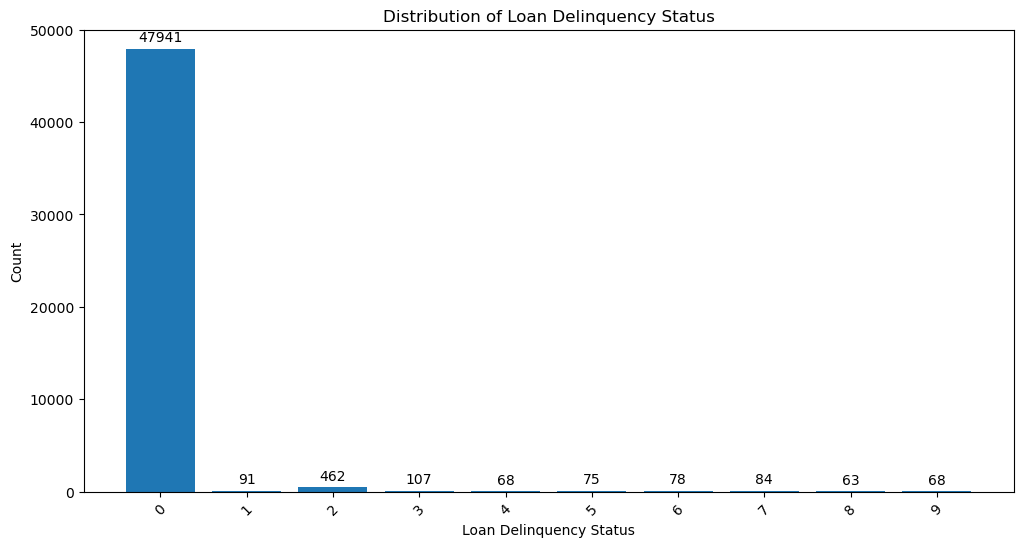

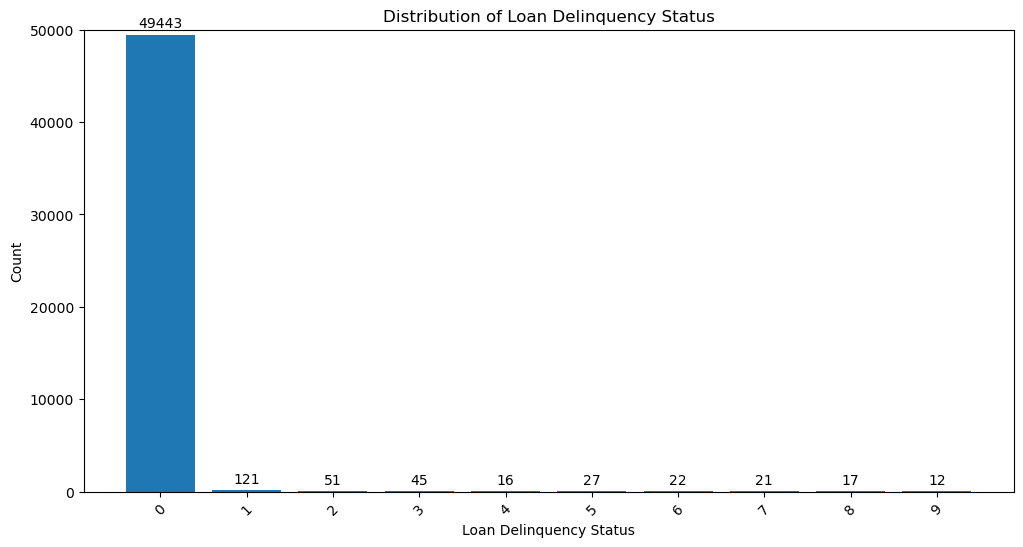

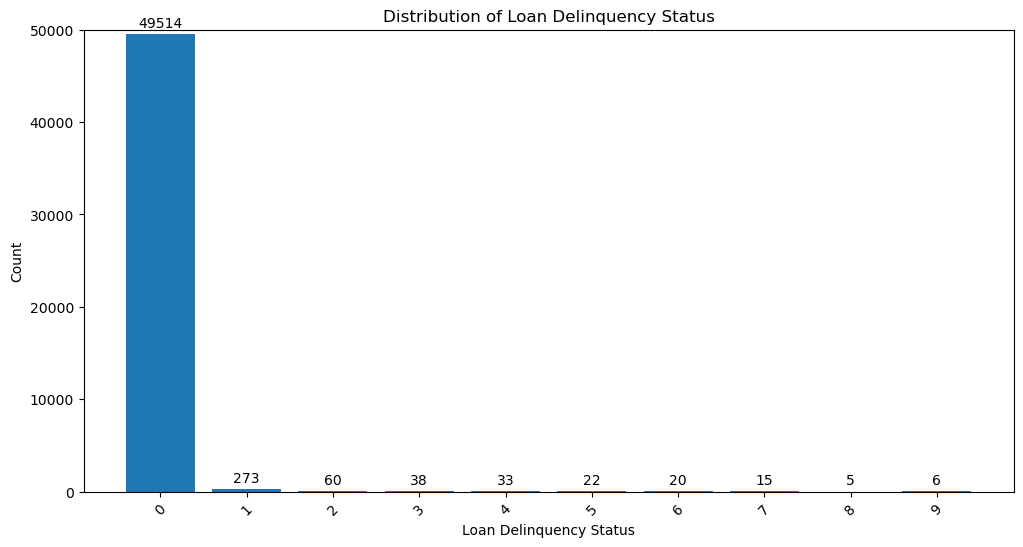

In [13]:
def plot_loan_delinquency_status(data, num_bars=10, y_limit=50000):
    # Count the loan status values
    status_counts = data['CURRENT LOAN DELINQUENCY STATUS'].value_counts()

    # Sort the status counts by index to ensure proper order
    status_counts = status_counts.sort_index()

    # Create the bar chart with smaller y-axis limits
    plt.figure(figsize=(12, 6))
    bars = plt.bar(status_counts.index[:num_bars], status_counts.values[:num_bars])  # Only the first n values
    plt.xlabel('Loan Delinquency Status')
    plt.ylabel('Count')
    plt.title('Distribution of Loan Delinquency Status')

    # Set y-axis limits to emphasize differences
    plt.ylim(0, y_limit)  # Adjust the limits as needed

    # Set x-axis ticks at intervals of 1 for the first n bars
    plt.xticks(status_counts.index[:num_bars], rotation=45)

    # Add count numbers on top of the first n bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.show()

# Display the title
display(Markdown('## Distribution of Loan Delinquency Status grouped by Loan Sequence Number for 2008, 2020, and 2022'))

# Plot the data for each year
plot_loan_delinquency_status(cleaned_2008)
plot_loan_delinquency_status(cleaned_2020)
plot_loan_delinquency_status(cleaned_2022)


## Distribution of Loan Delinquency Status

The loan delinquency statuses range from current or minor delays to more substantial delinquencies, with a significant portion of loans falling into the "current" (Loan Delinquency Status 1) or "less than 30 days past due" (Loan Delinquency Status 2) category across all three datasets.

The overall trend of the graph demonstrates an exponential shape. In all three instances, the frequency of level 1 is significantly lower than at least 10% of level 0, indicating that most customers in 2020 and 2022 have good loan repayment habits each month. Regarding the 2008 dataset, this might reflect the popularity of mortgage-related financing products in 2008, and loan repayment habits were not as good as in 2020 and 2022.

## Analyzing Delinquency Rate by Credit Score

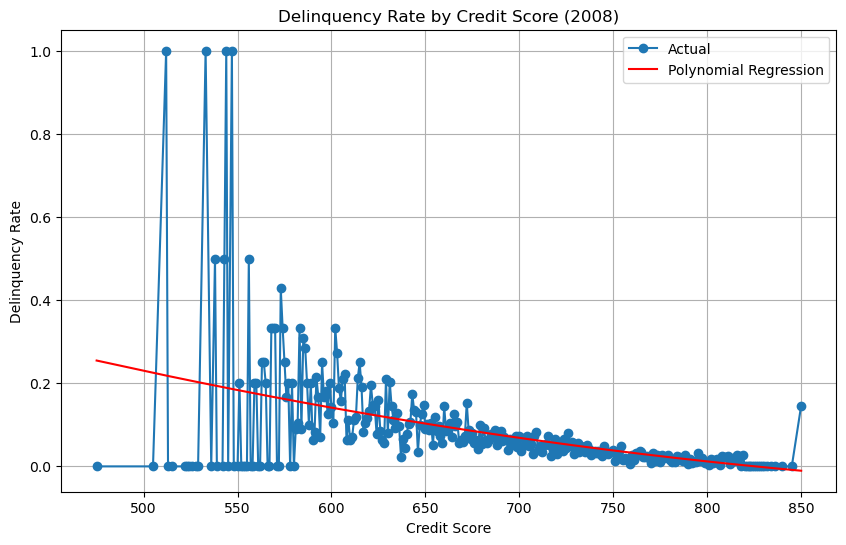

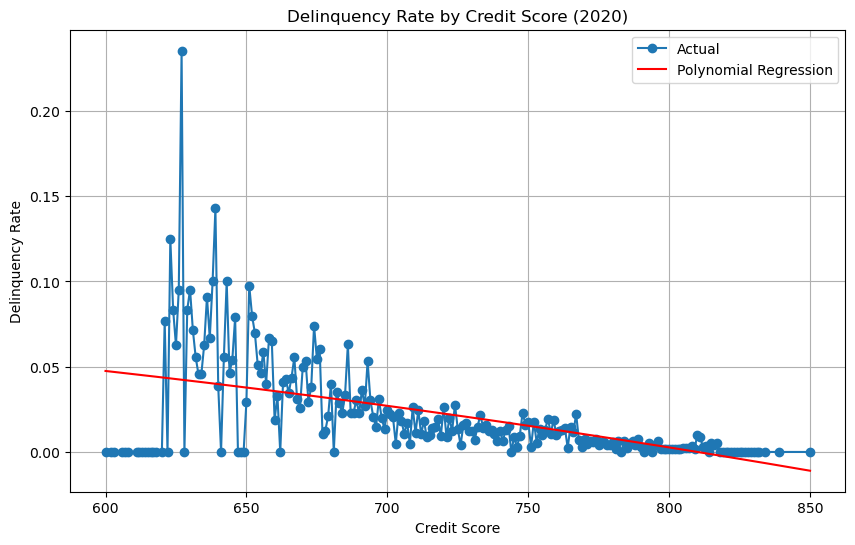

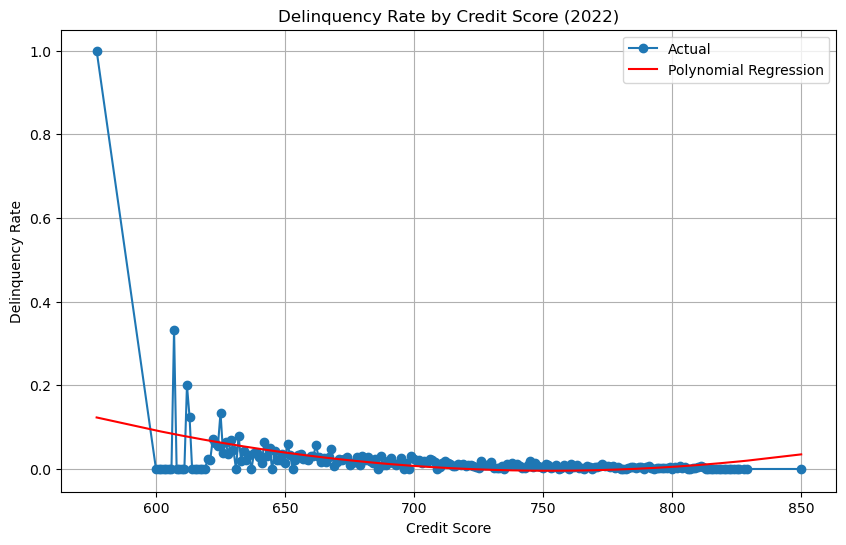

In [14]:
# Display the title
display(Markdown('## Analyzing Delinquency Rate by Credit Score'))

def process_and_plot(cleaned_data, title):
    # Function to calculate delinquency rate
    def calculate_delinquency_rate(data, credit_score_col, delinquency_col, threshold=1):
        # Create a new column 'DELINQUENT' to indicate whether the loan is delinquent
        data['DELINQUENT'] = data[delinquency_col].apply(lambda x: 1 if x >= threshold else 0)
        # Group by credit score and calculate the mean delinquency rate
        delinquency_rate = data.groupby(credit_score_col)['DELINQUENT'].mean()
        return delinquency_rate

    # Calculate the delinquency rate
    delinquency_rate = calculate_delinquency_rate(cleaned_data, 'CREDIT SCORE', 'CURRENT LOAN DELINQUENCY STATUS')

    # Prepare data for polynomial regression
    X = delinquency_rate.index.values.reshape(-1, 1)
    y = delinquency_rate.values

    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)

    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict using the polynomial regression model
    y_poly_pred = model.predict(X_poly)

    # Plot the delinquency rate vs credit score and the polynomial regression curve
    plt.figure(figsize=(10, 6))
    plt.plot(delinquency_rate.index, delinquency_rate.values, marker='o', label='Actual')
    plt.plot(delinquency_rate.index, y_poly_pred, color='red', label='Polynomial Regression')
    plt.title(title)
    plt.xlabel('Credit Score')
    plt.ylabel('Delinquency Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot the data for each year
process_and_plot(cleaned_2008, 'Delinquency Rate by Credit Score (2008)')
process_and_plot(cleaned_2020, 'Delinquency Rate by Credit Score (2020)')
process_and_plot(cleaned_2022, 'Delinquency Rate by Credit Score (2022)')


## Credit Score and Delinquency Rate

We have observed that as the Credit Score increases, the delinquency rate tends to decrease. Individuals with higher credit scores are generally considered more creditworthy, and therefore, they are less likely to default on their loans. This inverse relationship between credit score and delinquency rate suggests that credit scores can be a valuable metric for lenders to assess the risk associated with lending.

Specifically, lower credit scores often correlate with higher delinquency rates, indicating a greater probability  of default. 

We also observed that Credit Score is the most effective parameter for predicting delinquency among all the variables. Therefore, we are now attempting to use Credit Score along with another variable to predict delinquency, aiming for better accuracy.

## Using Credit Score and Original Interest Rate to predict Delinquency Rate by applying 3D plot

From the following 3D plot, there is not a clear pattern

# Exploring Delinquency Rate by Credit Score and Original Interest Rate by 3D Plot

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     344.6
Date:                Thu, 08 Aug 2024   Prob (F-statistic):          2.32e-149
Time:                        22:07:39   Log-Likelihood:            -1.4101e+05
No. Observations:               49991   AIC:                         2.820e+05
Df Residuals:                   49988   BIC:                         2.821e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6669      0.382      6.987      0.0

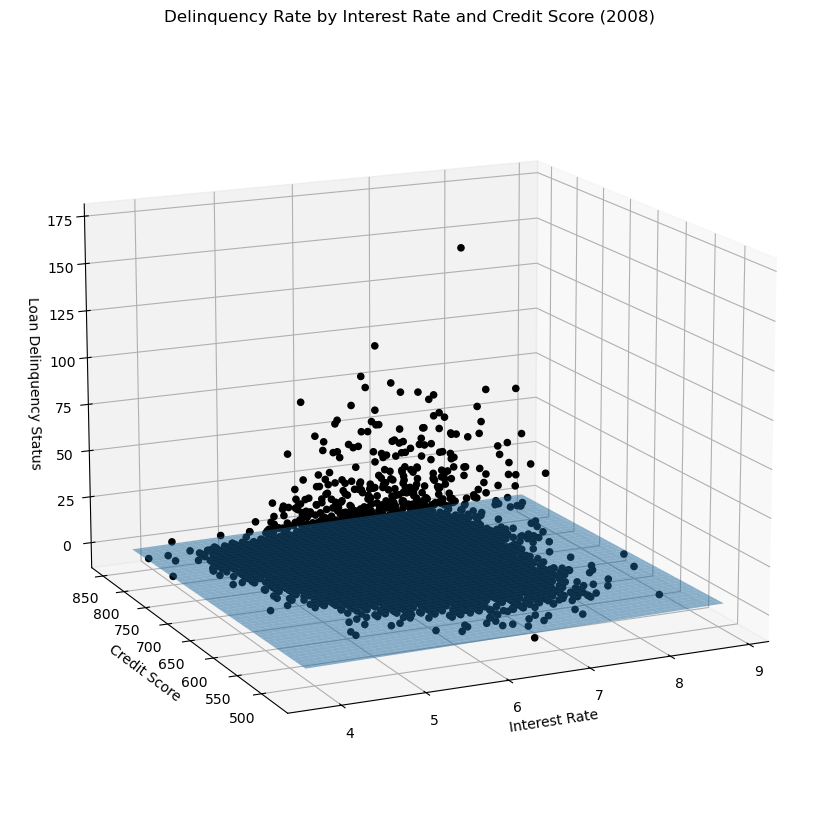

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     213.8
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           3.59e-93
Time:                        22:07:40   Log-Likelihood:                -76189.
No. Observations:               49999   AIC:                         1.524e+05
Df Residuals:                   49996   BIC:                         1.524e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8958      0.106      8.457      0.0

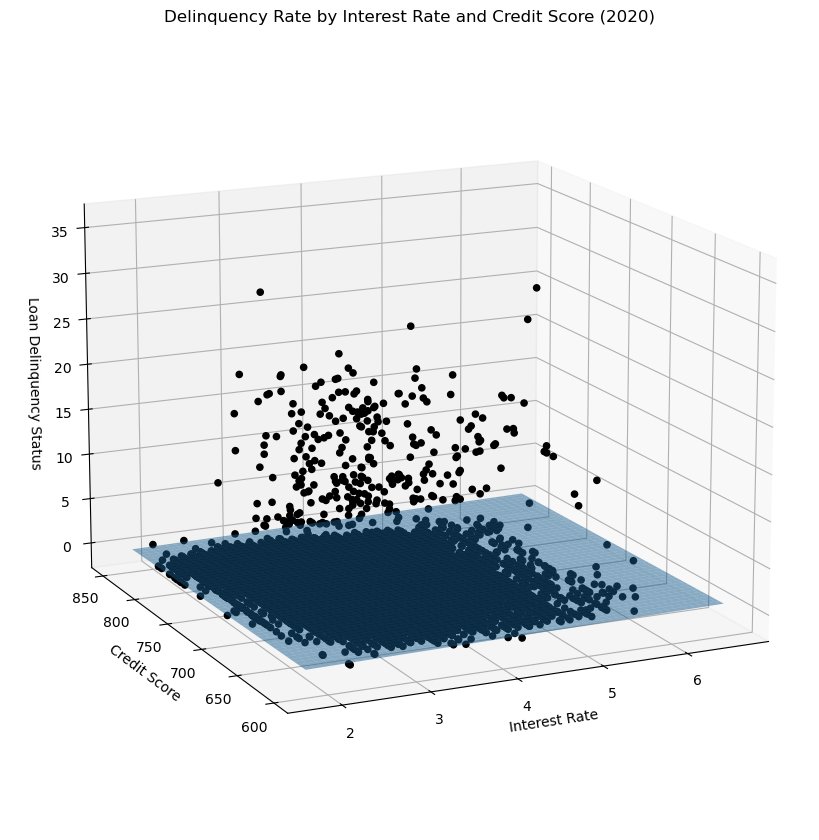

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     87.69
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           9.59e-39
Time:                        22:07:41   Log-Likelihood:                -16267.
No. Observations:               49998   AIC:                         3.254e+04
Df Residuals:                   49995   BIC:                         3.257e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3564      0.025     14.171      0.0

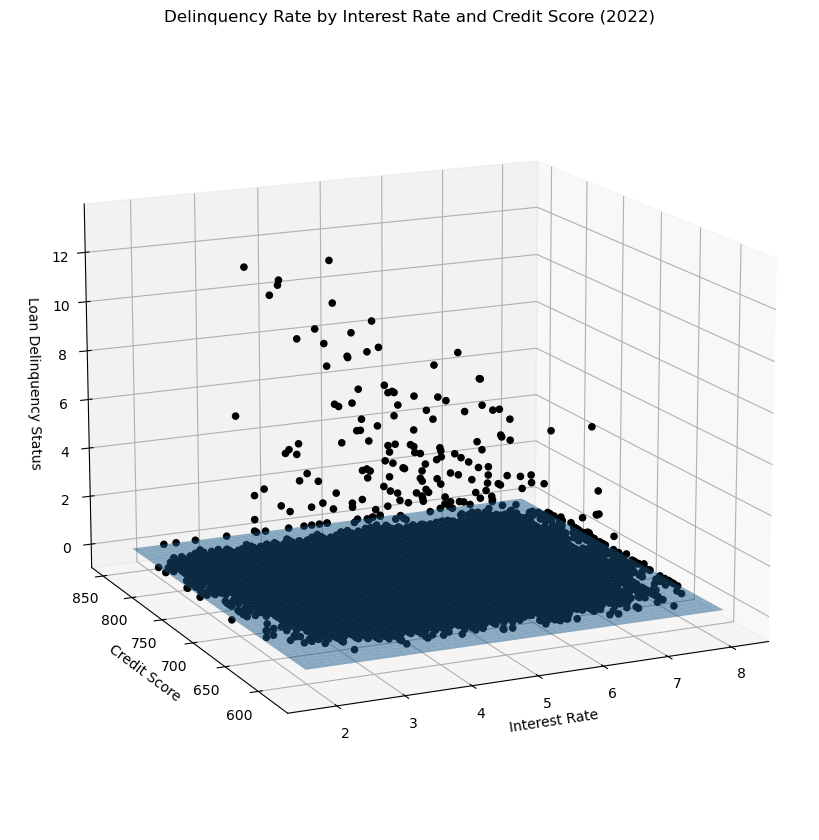

In [15]:
# Display the title
display(Markdown('# Exploring Delinquency Rate by Credit Score and Original Interest Rate by 3D Plot'))

def process_and_plot_3d(cleaned_data, title):
    # Select relevant columns
    x = cleaned_data['ORIGINAL INTEREST RATE']
    d = cleaned_data['CREDIT SCORE']
    y = cleaned_data['CURRENT LOAN DELINQUENCY STATUS']

    # Create a DataFrame for regression
    df = pd.DataFrame({'x': x, 'd': d, 'y': y})

    # Fit an OLS model
    reg_model = smf.ols(formula='y ~ d + x', data=df)
    ols = reg_model.fit()

    # Print the summary of the OLS model
    print(ols.summary())

    # Create a 3D plot
    xx1, xx2 = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                           np.linspace(d.min(), d.max(), 100))

    # Evaluate the model on a grid to plot the surface
    x_grid_val = np.array([xx1.ravel(), xx2.ravel()])[0]
    d_grid_val = np.array([xx1.ravel(), xx2.ravel()])[1]
    y_hat_grid = ols.predict(pd.DataFrame({'x': x_grid_val, 'd': d_grid_val})).values.reshape(xx1.shape)

    # Create matplotlib 3D axes
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig, azim=-115, elev=15, auto_add_to_figure=False)
    fig.add_axes(ax)

    # Plot data points
    ax.scatter(x, d, y, color='black', alpha=1)

    # Plot the surface
    surf = ax.plot_surface(xx1, xx2, y_hat_grid, alpha=0.5, linewidth=0)

    # Set axis labels
    ax.set_xlabel('Interest Rate')
    ax.set_ylabel('Credit Score')
    ax.set_zlabel('Loan Delinquency Status')
    plt.title(title)
    plt.show()

# Process and plot data for each year
process_and_plot_3d(cleaned_2008, 'Delinquency Rate by Interest Rate and Credit Score (2008)')
process_and_plot_3d(cleaned_2020, 'Delinquency Rate by Interest Rate and Credit Score (2020)')
process_and_plot_3d(cleaned_2022, 'Delinquency Rate by Interest Rate and Credit Score (2022)')


## Using Credit Score and Loan-To-Value to predict Delinquency Rate

We notived that using LTV and credit score to predict delinquency is more effective. A lower LTV ratio leads to a lower likelihood of default. Although there may be potential confounders in this relationship, the predictive power remains strong.

# Exploring Delinquency Rate by Credit Score and LOAN-TO-VALUE by 3D Plot

C:\Users\yxu\AppData\Local\Temp\ipykernel_42256\1838705186.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data.dropna(subset=['CURRENT_LOAN_DELINQUENCY_STATUS', 'CREDIT_SCORE', 'LTV'], inplace=True)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1264.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:07:43   Log-Likelihood:            -1.5876e+05
No. Observations:               49990   AIC:                         3.175e+05
Df Residuals:                   49987   BIC:                         3.176e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9019      0.409     41.363      0.0

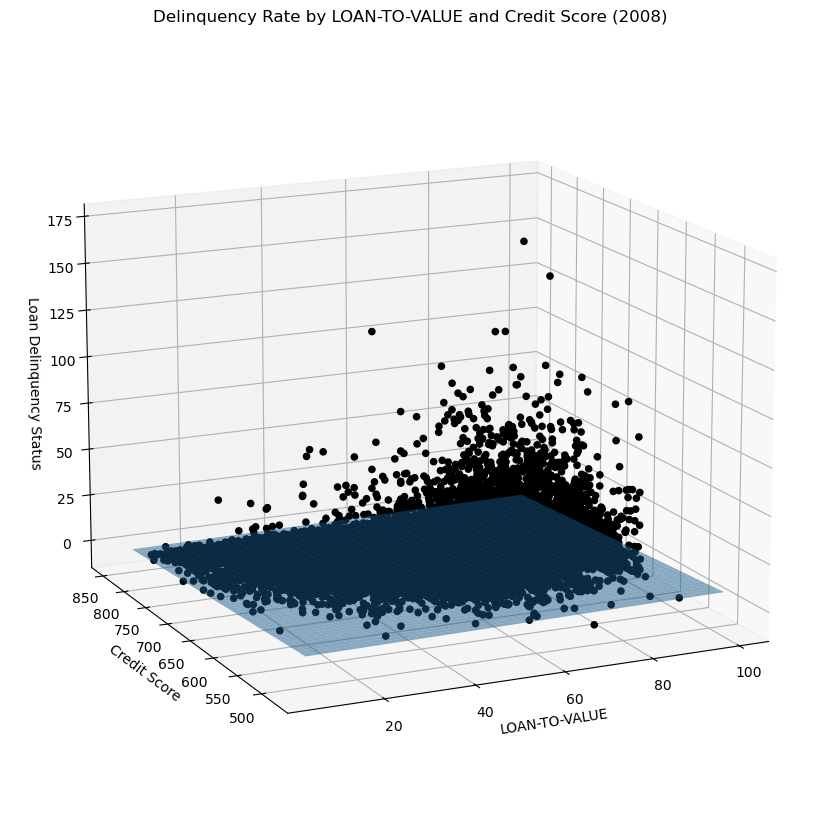

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     295.2
Date:                Thu, 08 Aug 2024   Prob (F-statistic):          3.70e-128
Time:                        22:07:45   Log-Likelihood:                -85569.
No. Observations:               49999   AIC:                         1.711e+05
Df Residuals:                   49996   BIC:                         1.712e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4862      0.117     21.322      0.0

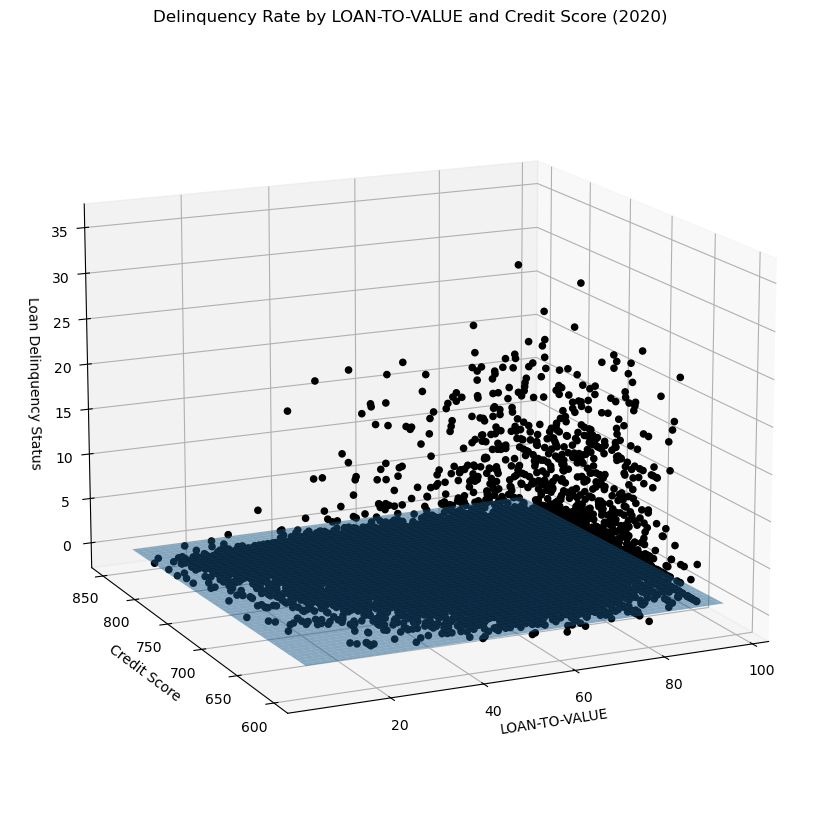

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     170.0
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           2.59e-74
Time:                        22:07:46   Log-Likelihood:                -22817.
No. Observations:               49998   AIC:                         4.564e+04
Df Residuals:                   49995   BIC:                         4.567e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5565      0.028     19.958      0.0

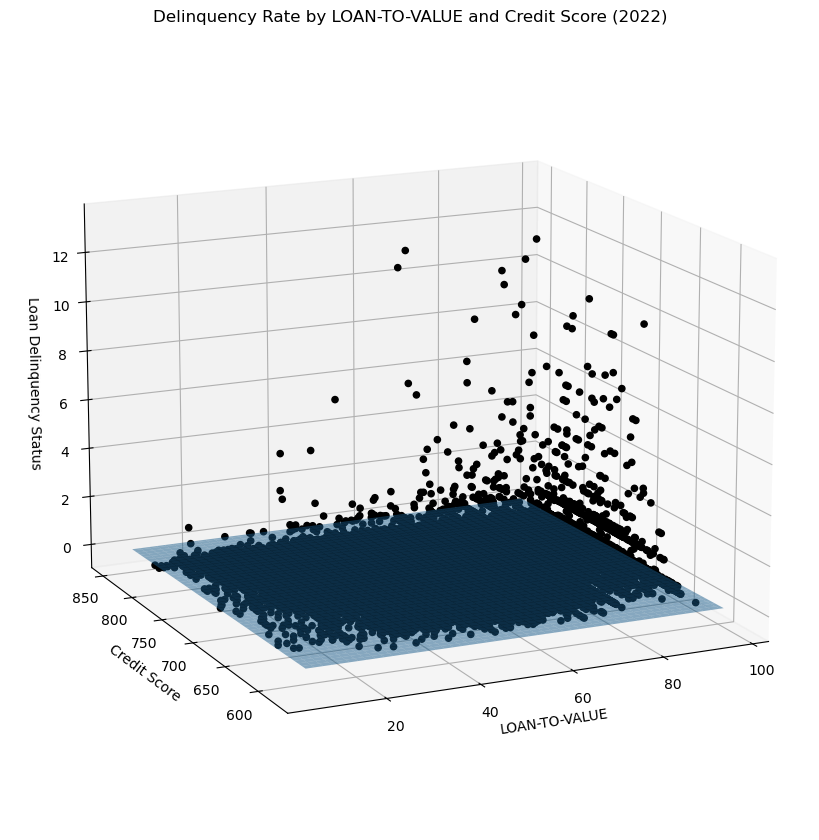

In [16]:
# Display the title
display(Markdown('# Exploring Delinquency Rate by Credit Score and LOAN-TO-VALUE by 3D Plot'))

def process_and_plot_3d(merged_data, title):
    # Rename columns to match the expected column names if necessary
    merged_data.rename(columns={
        'CREDIT SCORE': 'CREDIT_SCORE',
        'LOAN-TO-VALUE': 'LTV',
        'CURRENT LOAN DELINQUENCY STATUS': 'CURRENT_LOAN_DELINQUENCY_STATUS',
        'LOAN SEQUENCE NUMBER': 'LOAN_SEQUENCE_NUMBER'
    }, inplace=True)

    # Remove rows where CREDIT_SCORE is out of range and LTV is 999
    merged_data = merged_data[(merged_data['CREDIT_SCORE'] >= 300) & (merged_data['CREDIT_SCORE'] <= 850) & (merged_data['LTV'] != 999)]

    # Drop rows with missing values in specific columns
    merged_data.dropna(subset=['CURRENT_LOAN_DELINQUENCY_STATUS', 'CREDIT_SCORE', 'LTV'], inplace=True)

    # Group by LOAN_SEQUENCE_NUMBER and keep the record with the maximum CURRENT_LOAN_DELINQUENCY_STATUS for each group
    loan_delinquency_status = merged_data.loc[merged_data.groupby('LOAN_SEQUENCE_NUMBER')['CURRENT_LOAN_DELINQUENCY_STATUS'].idxmax()]

    # Select relevant columns
    x = loan_delinquency_status['LTV']
    d = loan_delinquency_status['CREDIT_SCORE']
    y = loan_delinquency_status['CURRENT_LOAN_DELINQUENCY_STATUS']

    # Create a DataFrame for regression
    df = pd.DataFrame({'x': x, 'd': d, 'y': y})

    # Fit an OLS model
    reg_model = smf.ols(formula='y ~ d + x', data=df)
    ols = reg_model.fit()

    # Print the summary of the OLS model
    print(ols.summary())

    # Create a 3D plot
    xx1, xx2 = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                           np.linspace(d.min(), d.max(), 100))

    # Evaluate the model on a grid to plot the surface
    x_grid_val = np.array([xx1.ravel(), xx2.ravel()])[0]
    d_grid_val = np.array([xx1.ravel(), xx2.ravel()])[1]
    y_hat_grid = ols.predict(pd.DataFrame({'x': x_grid_val, 'd': d_grid_val})).values.reshape(xx1.shape)

    # Create matplotlib 3D axes
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig, azim=-115, elev=15, auto_add_to_figure=False)
    fig.add_axes(ax)

    # Plot data points
    ax.scatter(x, d, y, color='black', alpha=1)

    # Plot the surface
    surf = ax.plot_surface(xx1, xx2, y_hat_grid, alpha=0.5, linewidth=0)

    # Set axis labels
    ax.set_xlabel('LOAN-TO-VALUE')
    ax.set_ylabel('Credit Score')
    ax.set_zlabel('Loan Delinquency Status')
    plt.title(title)
    plt.show()

# Process and plot data for each year
process_and_plot_3d(merged_2008, 'Delinquency Rate by LOAN-TO-VALUE and Credit Score (2008)')
process_and_plot_3d(merged_2020, 'Delinquency Rate by LOAN-TO-VALUE and Credit Score (2020)')
process_and_plot_3d(merged_2022, 'Delinquency Rate by LOAN-TO-VALUE and Credit Score (2022)')


# 2. Extract real time mortgage rates by API scraping

In [17]:
import requests
from bs4 import BeautifulSoup

def fetch_mortgage_rate(url, term_text):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the content of the response with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all table rows in the interest rates table
        rows = soup.find_all('tr')

        rate = None
        # Iterate through each row to find the one with the specified term text
        for row in rows:
            if term_text in row.text:
                # Extract the interest rate from the row (interest rate is usually the first cell)
                rate = row.find_all('td')[0].text.strip()
                break

        # Return the extracted rate or a not found message
        if rate:
            return rate
        else:
            return f"{term_text} not found"
    else:
        # Return an error message if the request was not successful
        return f"Failed to fetch data from the URL. Status code: {response.status_code}"

# URL of the mortgage rates page
url = 'https://www.bankrate.com/mortgages/mortgage-rates/#mortgage-news'

# Fetch mortgage rates for different terms
rate_10yr = fetch_mortgage_rate(url, '10-Year Fixed Rate')
rate_15yr = fetch_mortgage_rate(url, '15-Year Fixed Rate')
rate_20yr = fetch_mortgage_rate(url, '20-Year Fixed Rate')
rate_30yr = fetch_mortgage_rate(url, '30-Year Fixed Rate')

# Print the fetched rates
print(f"30 Yr. Fixed Mortgage Rate: {rate_30yr}")
print(f"20 Yr. Fixed Mortgage Rate: {rate_20yr}")
print(f"15 Yr. Fixed Mortgage Rate: {rate_15yr}")
print(f"10 Yr. Fixed Mortgage Rate: {rate_10yr}")

30 Yr. Fixed Mortgage Rate: 6.50%
20 Yr. Fixed Mortgage Rate: 6.19%
15 Yr. Fixed Mortgage Rate: 5.86%
10 Yr. Fixed Mortgage Rate: 5.82%


# 3. Identifing individuals in the dataset that would benefit from refinancing

In [18]:
# Combine cleaned data
combined_data = pd.concat([MPD2008, MPD2020, MPD2022], ignore_index=True)

# Calculate ORIGINAL LOAN TERM
combined_data['ORIGINAL LOAN TERM'] = combined_data['LOAN AGE'] + combined_data['REMAINING MONTHS TO LEGAL MATURITY']

# Filter to keep the record with the maximum 'LOAN AGE' for each 'LOAN SEQUENCE NUMBER'
combined_data = combined_data.loc[combined_data.groupby('LOAN SEQUENCE NUMBER')['LOAN AGE'].idxmax()]

# Reset the DataFrame index if needed
combined_data.reset_index(drop=True, inplace=True)

loan_sequence_number_count = combined_data['LOAN SEQUENCE NUMBER'].nunique()
# Display the first few rows of the cleaned data
combined_data.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,DEFECT SETTLEMENT DATE,MODIFICATION FLAG,ZERO BALANCE CODE,ZERO BALANCE EFFECTIVE DATE,...,STEP MODIFICATION FLAG,DEFERRED PAYMENT PLAN,ESTIMATED LOAN TO VALUE,ZERO BALANCE REMOVAL UPB,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB,ORIGINAL LOAN TERM
0,F08Q10000071,201207,0.0,0,53,307,NaN,NaN,1.0,201207.0,...,NaN,NaN,NaN,53688.65,NaN,NaN,NaN,NaN,0.0,360
1,F08Q10000079,201601,0.0,0,94,266,NaN,NaN,1.0,201601.0,...,NaN,NaN,NaN,152386.84,NaN,NaN,NaN,NaN,0.0,360
2,F08Q10000086,201205,0.0,0,51,309,NaN,NaN,1.0,201205.0,...,NaN,NaN,NaN,53286.69,NaN,NaN,NaN,NaN,0.0,360
3,F08Q10000220,201012,0.0,0,34,326,NaN,NaN,1.0,201012.0,...,NaN,NaN,NaN,275547.72,NaN,NaN,NaN,NaN,0.0,360
4,F08Q10000233,200903,0.0,0,13,347,NaN,NaN,1.0,200903.0,...,NaN,NaN,NaN,120875.36,NaN,NaN,NaN,NaN,0.0,360


In [19]:
# Define current mortgage rates
current_rates = {
    '10year': float(rate_10yr.replace('%', '')),
    '15year': float(rate_15yr.replace('%', '')),
    '20year': float(rate_20yr.replace('%', '')),
    '30year': float(rate_30yr.replace('%', ''))
}

# Function to classify loan term
def classify_loan_term(term):
    if term <= 150:  # Less than 12.5 years * 12 months
        return '10year'
    elif 150 < term <= 210:  # Between 12.5 and 17.5 years * 12 months
        return '15year'
    elif 210 < term <= 300:  # Between 17.5 and 25 years * 12 months
        return '20year'
    else:
        return '30year'

# Add a new column for loan term classification
combined_data['LOAN TERM GROUP'] = combined_data['ORIGINAL LOAN TERM'].apply(classify_loan_term)


In [20]:
# Function to calculate monthly payment
def calculate_monthly_payment(interest_rate, remaining_months, loan_balance):
    if interest_rate == 0 or loan_balance == 0 or remaining_months == 0:
        return 0
    monthly_interest_rate = (interest_rate / 100) / 12
    monthly_payment = loan_balance * (monthly_interest_rate * (1 + monthly_interest_rate) ** remaining_months) / ((1 + monthly_interest_rate) ** remaining_months - 1)
    return monthly_payment

# Calculate current and best payments
combined_data['Current payments'] = combined_data.apply(lambda row: calculate_monthly_payment(row['CURRENT INTEREST RATE'], row['REMAINING MONTHS TO LEGAL MATURITY'], row['CURRENT ACTUAL UPB']), axis=1)
combined_data['Best payments'] = combined_data.apply(lambda row: calculate_monthly_payment(current_rates[row['LOAN TERM GROUP']], row['REMAINING MONTHS TO LEGAL MATURITY'], row['CURRENT ACTUAL UPB']), axis=1)

# Calculate potential savings
combined_data['Potential savings'] = combined_data['Current payments'] - combined_data['Best payments']




In [23]:
# Ensure MODIFICATION COST column exists and fill missing values
combined_data['MODIFICATION COST'] = combined_data['MODIFICATION COST'].fillna(combined_data['CURRENT ACTUAL UPB'] * 0.03)

# Determine if refinancing is beneficial and filter for beneficial refinancing
refinance_candidates = combined_data[combined_data['Potential savings'] > 0]

# Calculate breakeven points
refinance_candidates['Breakeven months'] = refinance_candidates.apply(
    lambda row: row['MODIFICATION COST'] / row['Potential savings'], axis=1)

# Further filter for Remaining Months to Legal Maturity > Breakeven Period (months)
refinance_candidates = refinance_candidates[refinance_candidates['REMAINING MONTHS TO LEGAL MATURITY'] > refinance_candidates['Breakeven months']]

# Format the output and add real-time interest rate
formatted_output = refinance_candidates.copy()
formatted_output['Real Time Interest Rate (%)'] = formatted_output['LOAN TERM GROUP'].apply(lambda x: current_rates[x])

# Select and rename columns
formatted_output = formatted_output[['LOAN SEQUENCE NUMBER', 'ORIGINAL LOAN TERM', 'CURRENT INTEREST RATE', 'Real Time Interest Rate (%)', 'REMAINING MONTHS TO LEGAL MATURITY', 'Potential savings', 'Breakeven months', 'MODIFICATION COST', 'CURRENT ACTUAL UPB']]
formatted_output.columns = ['Loan Sequence Number', 'Original Loan Term (months)', 'Current Interest Rate (%)', 'Real Time Interest Rate (%)', 'Remaining Months to Legal Maturity', 'Potential Savings ($)', 'Breakeven Period (months)', 'Modification Cost ($)', 'Current Actual UPB ($)']

formatted_output.head(10)

C:\Users\yxu\AppData\Local\Temp\ipykernel_42256\2858600093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refinance_candidates['Breakeven months'] = refinance_candidates.apply(


,Loan Sequence Number,Original Loan Term (months),Current Interest Rate (%),Real Time Interest Rate (%),Remaining Months to Legal Maturity,Potential Savings ($),Breakeven Period (months),Modification Cost ($),Current Actual UPB ($)
367,F08Q10018674,360,6.875,6.5,179,7.443123,144.778831,1077.6066,35920.22
385,F08Q10019502,360,6.875,6.5,179,13.720467,144.778831,1986.4332,66214.44
408,F08Q10020441,360,7.750,6.5,179,10.091498,42.809265,432.0096,14400.32
422,F08Q10021018,360,7.500,6.5,212,27.089833,51.600596,1397.8515,46595.05
456,F08Q10022390,480,7.000,6.5,379,27.464344,-5.225321,-143.5100,81447.05
537,F08Q10025270,360,7.750,6.5,179,27.435040,42.809265,1174.4739,39149.13
550,F08Q10025881,360,7.000,6.5,179,10.351881,108.356565,1121.6943,37389.81
680,F08Q10031738,360,7.375,6.5,278,58.353520,55.037148,3211.6113,107053.71
736,F08Q10033721,360,7.125,6.5,335,134.389941,73.508223,9878.7657,329292.19
853,F08Q10039043,360,7.250,6.5,199,11.826165,70.185041,830.0199,27667.33


## The Loan Sequence Number that would benefit from refinancing 

In [36]:
# Identify loan sequence numbers that can benefit from refinancing
beneficial_loans_df = formatted_output

# Get the loan sequence numbers
beneficial_loans = beneficial_loans_df['Loan Sequence Number'].values

# Count the number of beneficial loans
beneficial_loans_count = len(beneficial_loans)

# Display the results
print(f"The total amount of Loan Sequence Number is: {loan_sequence_number_count}")
print(f"Number of loans that can benefit from refinancing: {beneficial_loans_count}")
print("The first 20 Loans that can benefit from refinancing:")
for loan in beneficial_loans[:20]:  # Display only the first 20 loan sequence numbers
    print(loan)

The total amount of Loan Sequence Number is: 149991
Number of loans that can benefit from refinancing: 5147
The first 20 Loans that can benefit from refinancing:
F08Q10018674
F08Q10019502
F08Q10020441
F08Q10021018
F08Q10022390
F08Q10025270
F08Q10025881
F08Q10031738
F08Q10033721
F08Q10039043
F08Q10042954
F08Q10043384
F08Q10045334
F08Q10045548
F08Q10049936
F08Q10057825
F08Q10058884
F08Q10101656
F08Q10107363
F08Q10130195


In [38]:
# Display beneficial loan sequence numbers
beneficial_loans = formatted_output[formatted_output['Breakeven Period (months)'].notna()]
loan_sequence_numbers = beneficial_loans['Loan Sequence Number']

# Get user input for the loan sequence number
loan_sequence_number = input("Enter the loan sequence number: ")

# Filter the DataFrame to select the loan with the given sequence number
loan = formatted_output[formatted_output['Loan Sequence Number'] == loan_sequence_number]

if loan.empty:
    print("Loan not found")
else:
    breakeven_period = loan['Breakeven Period (months)'].values[0]
    if pd.isna(breakeven_period):
        print("Not beneficial")
    else:
        print(f"Beneficial with a breakeven period of {breakeven_period:.2f} months")

Enter the loan sequence number:  F08Q10049936


Beneficial with a breakeven period of 124.86 months


# 4. Interactive Tool for User-Specific Mortgage Refinancing Analysis and Recommendations

## Delinquency Risk Prediction Modeling

#### The goal of the Delinquency Risk Prediction Modeling is to minimize False Positives (Type I Errors) and False Negatives (Type II Errors).

Type I Error (False Positive) occurs when the model incorrectly predicts a loan will become delinquent. This can lead to unnecessary lender actions and additional costs. Precision measures the proportion of correct positive predictions, with lower precision indicating more Type I errors. In this case, the model predicts a loan will become delinquent when it will not.

Type II Error (False Negative) happens when the model fails to predict a delinquent loan. This increases financial risks and default rates. Recall measures the proportion of actual positives correctly identified, with lower recall indicating more Type II errors. Under this situation, the model predicts a loan will not become delinquent when it actually will.

### 1. Data Cleaning

In [40]:
# Combine cleaned data
combined_cleaned_data = pd.concat([cleaned_2008, cleaned_2020, cleaned_2022], ignore_index=True)

# Define selected columns (using actual existing column names)
selected_columns = ['LOAN SEQUENCE NUMBER', 'CREDIT SCORE', 'ORIGINAL UPB', 'ORIGINAL INTEREST RATE', 'CURRENT LOAN DELINQUENCY STATUS', 'LOAN AGE', 
                    'REMAINING MONTHS TO LEGAL MATURITY', 'BORROWER ASSISTANCE STATUS CODE', 
                    'LTV', 'CLTV', 'DTI RATIO', 'CURRENT ACTUAL UPB', 'NUMBER OF BORROWERS', 'NUMBER OF UNITS', 
                    'HAS EVER DELINQUENT']

# Select specific columns
df_selected = combined_cleaned_data[selected_columns].copy()

# Replace NaN values with 0
df_selected = df_selected.fillna(0)

# Replace DTI RATIO value of 999 with the median value of DTI RATIO
df_selected['DTI RATIO'] = df_selected['DTI RATIO'].replace(999, df_selected['DTI RATIO'].median())

# Convert categorical features to numerical if needed
df_selected['BORROWER ASSISTANCE STATUS CODE'] = pd.to_numeric(df_selected['BORROWER ASSISTANCE STATUS CODE'], errors='coerce')
df_selected['NUMBER OF BORROWERS'] = pd.to_numeric(df_selected['NUMBER OF BORROWERS'], errors='coerce')


# Fill remaining NaN values with 0
df_selected = df_selected.fillna(0)

# Display the first few rows of data
df_selected.head(10)

,LOAN SEQUENCE NUMBER,CREDIT SCORE,ORIGINAL UPB,ORIGINAL INTEREST RATE,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,BORROWER ASSISTANCE STATUS CODE,LTV,CLTV,DTI RATIO,CURRENT ACTUAL UPB,NUMBER OF BORROWERS,NUMBER OF UNITS,HAS EVER DELINQUENT
0,F08Q10000079,782,171000,6.375,0.0,94,266,0.0,40,40,37,0.00,1,1,0
1,F08Q10000086,685,58000,7.125,0.0,51,309,0.0,80,80,25,0.00,1,1,0
2,F08Q10000220,776,290000,5.875,0.0,34,326,0.0,60,60,23,0.00,1,1,0
3,F08Q10000233,735,122000,6.000,0.0,13,347,0.0,85,85,20,0.00,2,1,0
4,F08Q10000307,797,102000,6.375,0.0,13,347,0.0,80,80,15,0.00,1,1,0
5,F08Q10000318,653,85000,5.875,0.0,18,342,0.0,62,62,34,0.00,1,1,0
6,F08Q10000392,710,225000,6.250,0.0,100,140,0.0,78,78,31,218090.58,2,1,1
7,F08Q10000395,780,195000,6.250,0.0,1,359,0.0,80,80,19,0.00,2,1,0
8,F08Q10000402,682,76000,6.250,0.0,181,179,0.0,95,95,23,54052.29,2,1,0
9,F08Q10000410,710,37000,5.875,0.0,4,176,0.0,39,39,30,0.00,1,1,0


In the selected variables above, I have retained the majority of the numerical variables from the dataset, along with a few categorical variables, and an additional variable I created, 'HAS EVER DELINQUENT'. These variables will be used for the subsequent modeling.

### 2. Training Prediction Model

In [42]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Assume Delinquency Risk threshold is 1, i.e., CURRENT LOAN DELINQUENCY STATUS >= 2 indicates risk
df_selected['DELINQUENCY RISK'] = df_selected['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 1 if x >= 2 else 0)

# Select the features and target variable
X = df_selected.drop(['CURRENT LOAN DELINQUENCY STATUS', 'DELINQUENCY RISK', 'LOAN SEQUENCE NUMBER'], axis=1)
y = df_selected['DELINQUENCY RISK']

# Split the dataset into training set (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define custom loss function to handle class imbalance
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

# Build the model
model = Sequential([
    Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Save the model
model.save('focal_loss_model.h5')

# Predict the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

display(Markdown('## Model 1: Focal Loss Enhanced Neural Network Model'))
# Print evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("ROC AUC Score: {:.2f}".format(roc_auc))

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
cm1 = confusion_matrix(y_test, y_pred)
print(cm1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


## Model 1: Focal Loss Enhanced Neural Network Model

Accuracy: 0.94
Precision: 0.21
Recall: 0.95
F1 Score: 0.35
ROC AUC Score: 0.94

Confusion Matrix:
[[27806  1709]
 [   26   457]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29515
           1       0.21      0.95      0.35       483

    accuracy                           0.94     29998
   macro avg       0.61      0.94      0.66     29998
weighted avg       0.99      0.94      0.96     29998



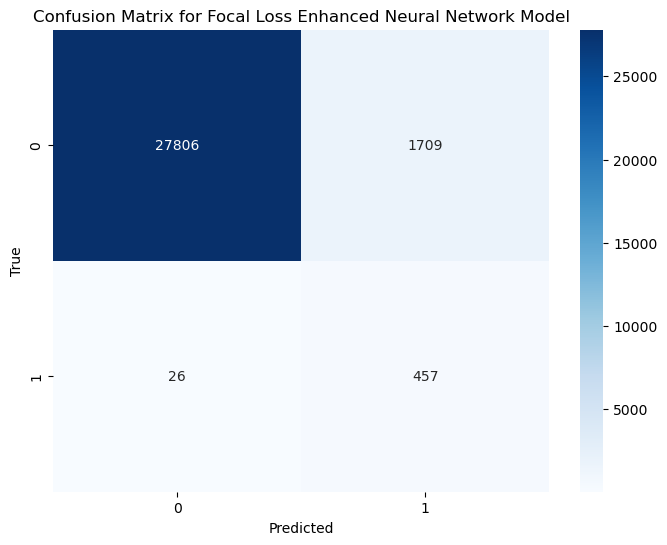

In [46]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Focal Loss Enhanced Neural Network Model")
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Assume Delinquency Risk threshold is 1, i.e., CURRENT LOAN DELINQUENCY STATUS >= 2 indicates risk
df_selected['DELINQUENCY RISK'] = df_selected['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 1 if x >= 2 else 0)

# Select the features and target variable
X = df_selected.drop(['CURRENT LOAN DELINQUENCY STATUS', 'DELINQUENCY RISK', 'LOAN SEQUENCE NUMBER'], axis=1)
y = df_selected['DELINQUENCY RISK']

# Split the dataset into training set (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model using Balanced Random Forest
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

display(Markdown('## Model 2: Balanced Random Forest Classifier'))
# Print evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("ROC AUC Score: {:.2f}".format(roc_auc))

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


## Model 2: Balanced Random Forest Classifier

Accuracy: 0.93
Precision: 0.18
Recall: 1.00
F1 Score: 0.30
ROC AUC Score: 0.96

Confusion Matrix:
[[27302  2213]
 [    0   483]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     29515
           1       0.18      1.00      0.30       483

    accuracy                           0.93     29998
   macro avg       0.59      0.96      0.63     29998
weighted avg       0.99      0.93      0.95     29998



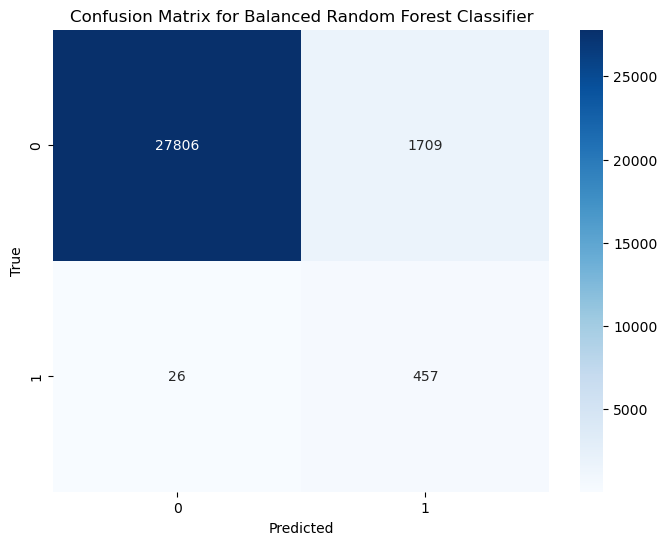

In [50]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Balanced Random Forest Classifier")
plt.show()

In [69]:
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Assume Delinquency Risk threshold is 1
df_selected['DELINQUENCY RISK'] = df_selected['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 1 if x >= 2 else 0)

# Select the features and target variable
X = df_selected.drop(['CURRENT LOAN DELINQUENCY STATUS', 'DELINQUENCY RISK', 'LOAN SEQUENCE NUMBER'], axis=1)
y = df_selected['DELINQUENCY RISK']

# Split the dataset into training set (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Predict the test set with XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Combine XGBoost predictions with Balanced Random Forest
brf_model = BalancedRandomForestClassifier(random_state=42)
brf_model.fit(X_train, y_train)

# Predict the test set with Balanced Random Forest
y_pred_brf = brf_model.predict(X_test)

# Evaluate the Balanced Random Forest model
accuracy_brf = accuracy_score(y_test, y_pred_brf)
precision_brf = precision_score(y_test, y_pred_brf)
recall_brf = recall_score(y_test, y_pred_brf)
f1_brf = f1_score(y_test, y_pred_brf)
roc_auc_brf = roc_auc_score(y_test, y_pred_brf)

# Averaging the predictions for an ensemble approach
y_pred_ensemble = (y_pred_xgb + y_pred_brf) / 2 > 0.5

# Evaluate the Ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test, y_pred_ensemble)
display(Markdown('## Model 3: Ensemble Model (XGBoost + Balanced Random Forest)'))
print("Accuracy: {:.2f}".format(accuracy_ensemble))
print("Precision: {:.2f}".format(precision_ensemble))
print("Recall: {:.2f}".format(recall_ensemble))
print("F1 Score: {:.2f}".format(f1_ensemble))
print("ROC AUC Score: {:.2f}".format(roc_auc_ensemble))

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
cm3 = confusion_matrix(y_test, y_pred)
print(cm3)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


## Model 3: Ensemble Model (XGBoost + Balanced Random Forest)

Accuracy: 0.96
Precision: 0.26
Recall: 0.80
F1 Score: 0.39
ROC AUC Score: 0.88

Confusion Matrix:
[[28986   529]
 [  245   238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     29515
           1       0.31      0.49      0.38       483

    accuracy                           0.97     29998
   macro avg       0.65      0.74      0.68     29998
weighted avg       0.98      0.97      0.98     29998



In [89]:
# Assume Delinquency Risk threshold is 1, i.e., CURRENT LOAN DELINQUENCY STATUS >= 2 indicates risk
df_selected['DELINQUENCY RISK'] = df_selected['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 1 if x >= 2 else 0)

# Select the features and target variable
X = df_selected.drop(['CURRENT LOAN DELINQUENCY STATUS', 'DELINQUENCY RISK', 'LOAN SEQUENCE NUMBER'], axis=1)
y = df_selected['DELINQUENCY RISK']

# Split the dataset into training set (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define custom loss function to handle class imbalance for Focal Loss Neural Network
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

# Build and train Focal Loss Enhanced Neural Network Model
model_focal = Sequential([
    Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_focal.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_focal.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
model_focal.save('focal_loss_model.h5')

# Predict with Focal Loss Neural Network Model
y_pred_focal_prob = model_focal.predict(X_test).flatten()  # Ensure output is 1D
y_pred_focal = (y_pred_focal_prob > 0.5).astype("int32")

# Train and predict with XGBoost Model
model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb.fit(X_train_resampled, y_train_resampled)

# Save the XGBoost model
model_xgb.save_model('xgboost_model.json')

y_pred_xgb_prob = model_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_pred_xgb_prob > 0.5).astype("int32")

# Train and predict with Balanced Random Forest Model
model_rf = BalancedRandomForestClassifier(random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

# Save the Balanced Random Forest model
joblib.dump(model_rf, 'balanced_random_forest_model.pkl')

y_pred_rf_prob = model_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_rf_prob > 0.5).astype("int32")

# Ensemble the models using averaging
y_pred_ensemble_prob = (y_pred_focal_prob + y_pred_xgb_prob + y_pred_rf_prob) / 3
y_pred_ensemble = (y_pred_ensemble_prob > 0.5).astype(int)  # Convert to binary (0 or 1)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test, y_pred_ensemble)

# Print evaluation metrics
display(Markdown('## Model 4: Ensemble Model (Focal Loss Enhanced Neural Network, XGBoost, and Balanced Random Forest)'))
print("Accuracy: {:.2f}".format(accuracy_ensemble))
print("Precision: {:.2f}".format(precision_ensemble))
print("Recall: {:.2f}".format(recall_ensemble))
print("F1 Score: {:.2f}".format(f1_ensemble))
print("ROC AUC Score: {:.2f}".format(roc_auc_ensemble))

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
cm4 = confusion_matrix(y_test, y_pred_ensemble)
print(cm4)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
D:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


## Model 4: Ensemble Model (Focal Loss Enhanced Neural Network, XGBoost, and Balanced Random Forest)

Accuracy: 0.97
Precision: 0.31
Recall: 0.60
F1 Score: 0.41
ROC AUC Score: 0.79

Confusion Matrix:
[[28874   641]
 [  191   292]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     29515
           1       0.31      0.60      0.41       483

    accuracy                           0.97     29998
   macro avg       0.65      0.79      0.70     29998
weighted avg       0.98      0.97      0.98     29998



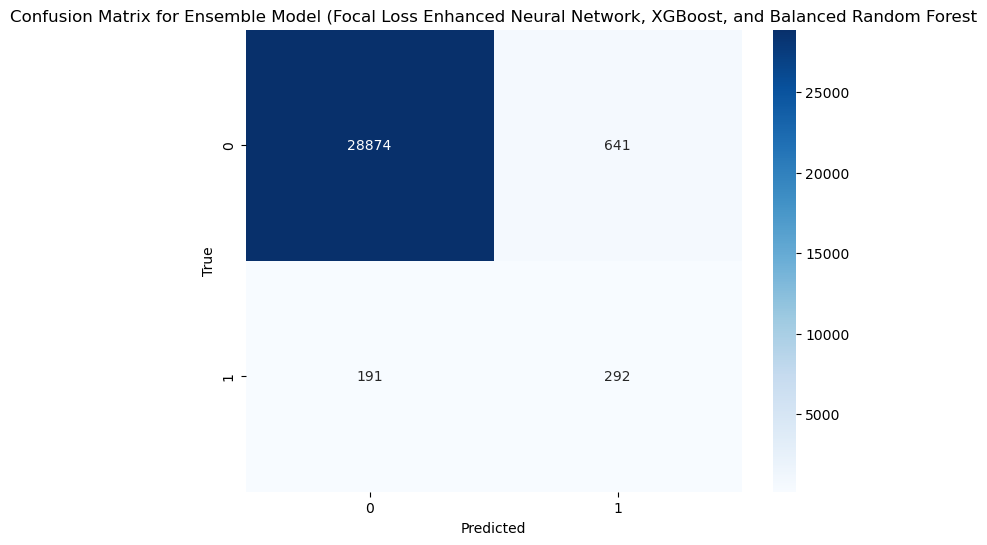

In [91]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Ensemble Model (Focal Loss Enhanced Neural Network, XGBoost, and Balanced Random Forest")
plt.show()

#### Comparing the four models above, the Model 4: Ensemble Model(Focal Loss Enhanced Neural Network, XGBoost, and Balanced Random Forest) demonstrates superior performance in predicting Delinquency Risk. Therefore, I will use it in the following GUI to provide results based on the input.

#### However, it is important to note that over 99% of the users (Loan Sequence Numbers) in our data do not have delinquency records, or if they did, they subsequently repaid the loan. As a result, our model has low precision in its recall accuracy.

## User Interface Tool for predicting delinquency risk with Model 4: Ensemble Model (Focal Loss Enhanced Neural Network, XGBoost, and Balanced Random Forest)

In [118]:
# Define custom loss function to handle class imbalance for Focal Loss Neural Network
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
        
    return focal_loss_fixed
# Load the trained focal loss model
model = load_model('focal_loss_model.h5', custom_objects={'focal_loss_fixed': focal_loss()})

# Load the XGBoost model
model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb.load_model('xgboost_model.json')  

# Load  the Balanced Random Forest model
model_rf = joblib.load('balanced_random_forest_model.pkl')

# Function to calculate recommendations based on input
def calculate_recommendations():
    try:
        # Retrieve and validate inputs
        credit_score = float(entry_credit_score.get())
        if not (300 <= credit_score <= 850):
            raise ValueError("Credit Score should be between 300 and 850")

        original_upb = float(entry_original_upb.get())
        if original_upb <= 0:
            raise ValueError("Original UPB should be a positive number")

        original_interest_rate = float(entry_original_interest_rate.get())
        if original_interest_rate <= 0:
            raise ValueError("Original Interest Rate should be a positive number")

        loan_age = float(entry_loan_age.get())
        if loan_age < 0:
            raise ValueError("Loan Age should be a non-negative number")

        remaining_months = float(entry_remaining_months.get())
        if remaining_months <= 0:
            raise ValueError("Remaining Months to Legal Maturity should be a positive number")

        borrower_assistance_status_code = float(entry_borrower_assistance_status_code.get())
        if borrower_assistance_status_code < 0:
            raise ValueError("Borrower Assistance Status Code should be a non-negative number")

        ltv = float(entry_ltv.get())
        if not (0 <= ltv <= 100):
            raise ValueError("LTV should be between 0 and 100")

        cltv = float(entry_cltv.get())
        if not (0 <= cltv <= 100):
            raise ValueError("CLTV should be between 0 and 100")

        dti_ratio = float(entry_dti_ratio.get())
        if not (0 <= dti_ratio <= 100):
            raise ValueError("DTI Ratio should be between 0 and 100")

        current_actual_upb = float(entry_current_actual_upb.get())
        if current_actual_upb <= 0:
            raise ValueError("Current Actual UPB should be a positive number")

        number_of_borrowers = int(entry_number_of_borrowers.get())
        if number_of_borrowers <= 0:
            raise ValueError("Number of Borrowers should be a positive integer")

        number_of_units = int(entry_number_of_units.get())
        if number_of_units <= 0:
            raise ValueError("Number of Units should be a positive integer")

        has_ever_delinquent = int(entry_has_ever_delinquent.get())
        if has_ever_delinquent not in [0, 1]:
            raise ValueError("Has Ever Delinquent should be 0 or 1")

        # Prepare the input data for the model
        input_data = np.array([[
            credit_score, original_upb, original_interest_rate, loan_age, 
            remaining_months, borrower_assistance_status_code, ltv, 
            cltv, dti_ratio, current_actual_upb, number_of_borrowers, number_of_units, 
            has_ever_delinquent
        ]])

        # Ensure input data has correct feature names
        input_df = pd.DataFrame(input_data, columns=[
            'CREDIT SCORE', 'ORIGINAL UPB', 'ORIGINAL INTEREST RATE', 'LOAN AGE', 
            'REMAINING MONTHS TO LEGAL MATURITY', 'BORROWER ASSISTANCE STATUS CODE', 
            'LTV', 'CLTV', 'DTI RATIO', 'CURRENT ACTUAL UPB', 'NUMBER OF BORROWERS', 'NUMBER OF UNITS', 
            'HAS EVER DELINQUENT'
        ])

        # Predict with each model
        y_pred_focal_prob = model_focal.predict(input_df).flatten()
        y_pred_xgb_prob = model_xgb.predict_proba(input_df)[:, 1]
        y_pred_rf_prob = model_rf.predict_proba(input_df)[:, 1]

        # Ensemble the models using averaging
        y_pred_ensemble_prob = (y_pred_focal_prob + y_pred_xgb_prob + y_pred_rf_prob) / 3
        risk_prediction = (y_pred_ensemble_prob > 0.5).astype(int)[0]

        # Display the result
        if risk_prediction > 0.5:
            recommendation_label.config(text="The client has a high risk of delinquency.")
        else:
            recommendation_label.config(text="The client has a low risk of delinquency.")

    except ValueError as e:
        messagebox.showerror("Input Error", str(e))
        return

        # Prepare the input data for the model
        input_data = np.array([[
            credit_score, original_upb, original_interest_rate, loan_age, 
            remaining_months, borrower_assistance_status_code, ltv, 
            cltv, dti_ratio, current_actual_upb, number_of_borrowers, number_of_units, 
            has_ever_delinquent
        ]])

        # Ensure input data has correct feature names
        input_df = pd.DataFrame(input_data, columns=[
            'CREDIT SCORE', 'ORIGINAL UPB', 'ORIGINAL INTEREST RATE', 'LOAN AGE', 
            'REMAINING MONTHS TO LEGAL MATURITY', 'BORROWER ASSISTANCE STATUS CODE', 
            'LTV', 'CLTV', 'DTI RATIO', 'CURRENT ACTUAL UPB', 'NUMBER OF BORROWERS', 'NUMBER OF UNITS', 
            'HAS EVER DELINQUENT'
        ])

        # Predict with each model
        y_pred_focal_prob = model_focal.predict(input_df).flatten()
        y_pred_xgb_prob = model_xgb.predict_proba(input_df)[:, 1]
        y_pred_rf_prob = model_rf.predict_proba(input_df)[:, 1]

        # Ensemble the models using averaging
        y_pred_ensemble_prob = (y_pred_focal_prob + y_pred_xgb_prob + y_pred_rf_prob) / 3
        risk_prediction = (y_pred_ensemble_prob > 0.5).astype(int)[0]

        # Display the result
        if risk_prediction > 0.5:
            recommendation_label.config(text="The client has a high risk of delinquency.")
        else:
            recommendation_label.config(text="The client has a low risk of delinquency.")

    except ValueError as e:
        messagebox.showerror("Input Error", str(e))

# Create the main GUI window (same as your original function)
root = tk.Tk()
root.title("Mortgage Delinquency Risk Prediction Tool")

# Labels and Entry widgets for user input
label_credit_score = tk.Label(root, text="Credit Score (300-850):")
label_credit_score.pack()
entry_credit_score = tk.Entry(root)
entry_credit_score.pack()

label_original_upb = tk.Label(root, text="Original UPB (positive number):")
label_original_upb.pack()
entry_original_upb = tk.Entry(root)
entry_original_upb.pack()

label_original_interest_rate = tk.Label(root, text="Original Interest Rate (positive number):")
label_original_interest_rate.pack()
entry_original_interest_rate = tk.Entry(root)
entry_original_interest_rate.pack()

label_loan_age = tk.Label(root, text="Loan Age (non-negative number):")
label_loan_age.pack()
entry_loan_age = tk.Entry(root)
entry_loan_age.pack()

label_remaining_months = tk.Label(root, text="Remaining Months to Legal Maturity (positive number):")
label_remaining_months.pack()
entry_remaining_months = tk.Entry(root)
entry_remaining_months.pack()

label_borrower_assistance_status_code = tk.Label(root, text="Borrower Assistance Status Code (non-negative number):")
label_borrower_assistance_status_code.pack()
entry_borrower_assistance_status_code = tk.Entry(root)
entry_borrower_assistance_status_code.pack()

label_ltv = tk.Label(root, text="LTV (0-100):")
label_ltv.pack()
entry_ltv = tk.Entry(root)
entry_ltv.pack()

label_cltv = tk.Label(root, text="CLTV (0-100):")
label_cltv.pack()
entry_cltv = tk.Entry(root)
entry_cltv.pack()

label_dti_ratio = tk.Label(root, text="DTI Ratio (0-100):")
label_dti_ratio.pack()
entry_dti_ratio = tk.Entry(root)
entry_dti_ratio.pack()

label_current_actual_upb = tk.Label(root, text="Current Actual UPB (positive number):")
label_current_actual_upb.pack()
entry_current_actual_upb = tk.Entry(root)
entry_current_actual_upb.pack()

label_number_of_borrowers = tk.Label(root, text="Number of Borrowers (positive integer):")
label_number_of_borrowers.pack()
entry_number_of_borrowers = tk.Entry(root)
entry_number_of_borrowers.pack()

label_number_of_units = tk.Label(root, text="Number of Units (positive integer):")
label_number_of_units.pack()
entry_number_of_units = tk.Entry(root)
entry_number_of_units.pack()

label_has_ever_delinquent = tk.Label(root, text="Has Ever Delinquent (0 or 1):")
label_has_ever_delinquent.pack()
entry_has_ever_delinquent = tk.Entry(root)
entry_has_ever_delinquent.pack()


# Button to calculate recommendations
calculate_button = tk.Button(root, text="Calculate Recommendations", command=calculate_recommendations)
calculate_button.pack()

# Label to display recommendations
recommendation_label = tk.Label(root, text="")
recommendation_label.pack()

# Start the GUI main loop
root.mainloop()

### User Interface Tool for Beneficial Loan Refinancing 

In [120]:
# Function to fetch mortgage rates from the website
def fetch_mortgage_rate(url, term_text):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        rows = soup.find_all('tr')
        rate = None
        for row in rows:
            if term_text in row.text:
                rate = row.find_all('td')[0].text.strip()
                break
        return rate if rate else f"{term_text} not found"
    else:
        return f"Failed to fetch data from the URL. Status code: {response.status_code}"

# URL of the mortgage rates page
url = 'https://www.bankrate.com/mortgages/mortgage-rates/#mortgage-news'

# Fetch mortgage rates for different terms
rate_10yr = fetch_mortgage_rate(url, '10-Year Fixed Rate')
rate_15yr = fetch_mortgage_rate(url, '15-Year Fixed Rate')
rate_20yr = fetch_mortgage_rate(url, '20-Year Fixed Rate')
rate_30yr = fetch_mortgage_rate(url, '30-Year Fixed Rate')

# Define current mortgage rates based on fetched data
current_rates = {
    '10year': float(rate_10yr.replace('%', '')),
    '15year': float(rate_15yr.replace('%', '')),
    '20year': float(rate_20yr.replace('%', '')),
    '30year': float(rate_30yr.replace('%', ''))
}

# Function to classify loan term
def classify_loan_term(term):
    if term <= 150:
        return '10year'
    elif 150 < term <= 210:
        return '15year'
    elif 210 < term <= 300:
        return '20year'
    else:
        return '30year'

# Function to calculate monthly payment
def calculate_monthly_payment(interest_rate, remaining_months, loan_balance):
    if interest_rate == 0 or loan_balance == 0 or remaining_months == 0:
        return 0
    monthly_interest_rate = (interest_rate / 100) / 12
    monthly_payment = loan_balance * (monthly_interest_rate * (1 + monthly_interest_rate) ** remaining_months) / ((1 + monthly_interest_rate) ** remaining_months - 1)
    return monthly_payment

# Function to calculate recommendations based on input
def calculate_recommendations():
    try:
        original_loan_term = float(entry_original_loan_term.get())
        current_interest_rate = float(entry_current_interest_rate.get())
        remaining_months = float(entry_remaining_months.get())
        current_actual_upb = float(entry_current_actual_upb.get())
        modification_cost = float(entry_modification_cost.get()) if entry_modification_cost.get() else current_actual_upb * 0.03

        # Validate inputs
        if original_loan_term < remaining_months:
            raise ValueError("Original Loan Term must be greater than or equal to Remaining Months to Legal Maturity")
        
        loan_term_group = classify_loan_term(original_loan_term)
        real_time_interest_rate = current_rates[loan_term_group]

        current_payment = calculate_monthly_payment(current_interest_rate, remaining_months, current_actual_upb)
        best_payment = calculate_monthly_payment(real_time_interest_rate, remaining_months, current_actual_upb)
        potential_savings = current_payment - best_payment

        if potential_savings <= 0:
            recommendation_label.config(text="Not beneficial")
            monthly_savings_label.config(text="")
            total_savings_label.config(text="")
        else:
            breakeven_months = modification_cost / potential_savings
            if breakeven_months > remaining_months:
                recommendation_label.config(text="Not beneficial")
                monthly_savings_label.config(text="")
                total_savings_label.config(text="")
            else:
                total_potential_savings = potential_savings * remaining_months
                recommendation_label.config(text=f"Beneficial with a breakeven period of {breakeven_months:.2f} months")
                monthly_savings_label.config(text=f"Monthly Potential Savings: ${potential_savings:.2f}")
                total_savings_label.config(text=f"Total Potential Savings: ${total_potential_savings:.2f}")

    except ValueError as e:
        messagebox.showerror("Input Error", str(e))
        return

# Create the main GUI window
root = tk.Tk()
root.title("Mortgage Refinance Beneficial and Breakeven Period Tool")

# Labels and Entry widgets for user input
label_original_loan_term = tk.Label(root, text="Original Loan Term (months):")
label_original_loan_term.pack()
entry_original_loan_term = tk.Entry(root)
entry_original_loan_term.pack()

label_current_interest_rate = tk.Label(root, text="Current Interest Rate (%):")
label_current_interest_rate.pack()
entry_current_interest_rate = tk.Entry(root)
entry_current_interest_rate.pack()

label_remaining_months = tk.Label(root, text="Remaining Months to Legal Maturity:")
label_remaining_months.pack()
entry_remaining_months = tk.Entry(root)
entry_remaining_months.pack()

label_current_actual_upb = tk.Label(root, text="Current Actual UPB ($):")
label_current_actual_upb.pack()
entry_current_actual_upb = tk.Entry(root)
entry_current_actual_upb.pack()

label_modification_cost = tk.Label(root, text="Modification Cost ($):")
label_modification_cost.pack()
entry_modification_cost = tk.Entry(root)
entry_modification_cost.pack()

# Button to calculate recommendations
calculate_button = tk.Button(root, text="Calculate Recommendations", command=calculate_recommendations)
calculate_button.pack()

# Label to display recommendations
recommendation_label = tk.Label(root, text="")
recommendation_label.pack()

# Labels to display potential savings
monthly_savings_label = tk.Label(root, text="")
monthly_savings_label.pack()

total_savings_label = tk.Label(root, text="")
total_savings_label.pack()

# Start the GUI main loop
root.mainloop()
